<a href="https://colab.research.google.com/github/xknobm00/MPA-MLF/blob/main/MLF_project_Knob_Hroch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPA-MLF-Final project 2025
## Classification 5G base stations
**Authors: Martin Knob, Vojtěch Hroch**

Mounts the Google Drive and sets up paths to access training and test data.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

import os

DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/MPA-MLF_DATA_NEW"
TRAIN_DIR = os.path.join(DATA_DIR, "Train")
TEST_DIR = os.path.join(DATA_DIR, "Test")
LABEL_FILE = os.path.join(DATA_DIR, "label_train.csv")
TEST_FORMAT_FILE = os.path.join(DATA_DIR, "test_format.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports all necessary libraries, including NumPy, Pandas, Matplotlib, Seaborn for visualization, and Keras/TensorFlow for model creation.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

!pip install keras-tuner
import keras_tuner as kt

Loads and preprocesses training samples and labels. Normalizes data and reshapes it to the required 2D CNN format.

In [25]:
label_df = pd.read_csv(LABEL_FILE)
label_df['file_path'] = label_df['ID'].apply(lambda x: os.path.join(TRAIN_DIR, f"{x}.npy"))

from tqdm import tqdm
X_data = np.array([np.load(f) for f in tqdm(label_df['file_path'])])
y_data = label_df['target'].values

X_data = X_data.astype('float32') / 255.0
X_data = X_data[..., np.newaxis]

100%|██████████| 1491/1491 [00:05<00:00, 271.05it/s]


Displays the class distribution in the dataset.

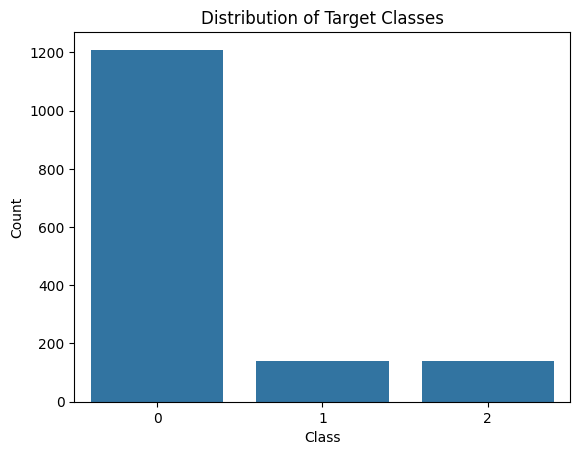

In [46]:
sns.countplot(x=y_data)
plt.title("Distribution of Target Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Visualizes random training samples.

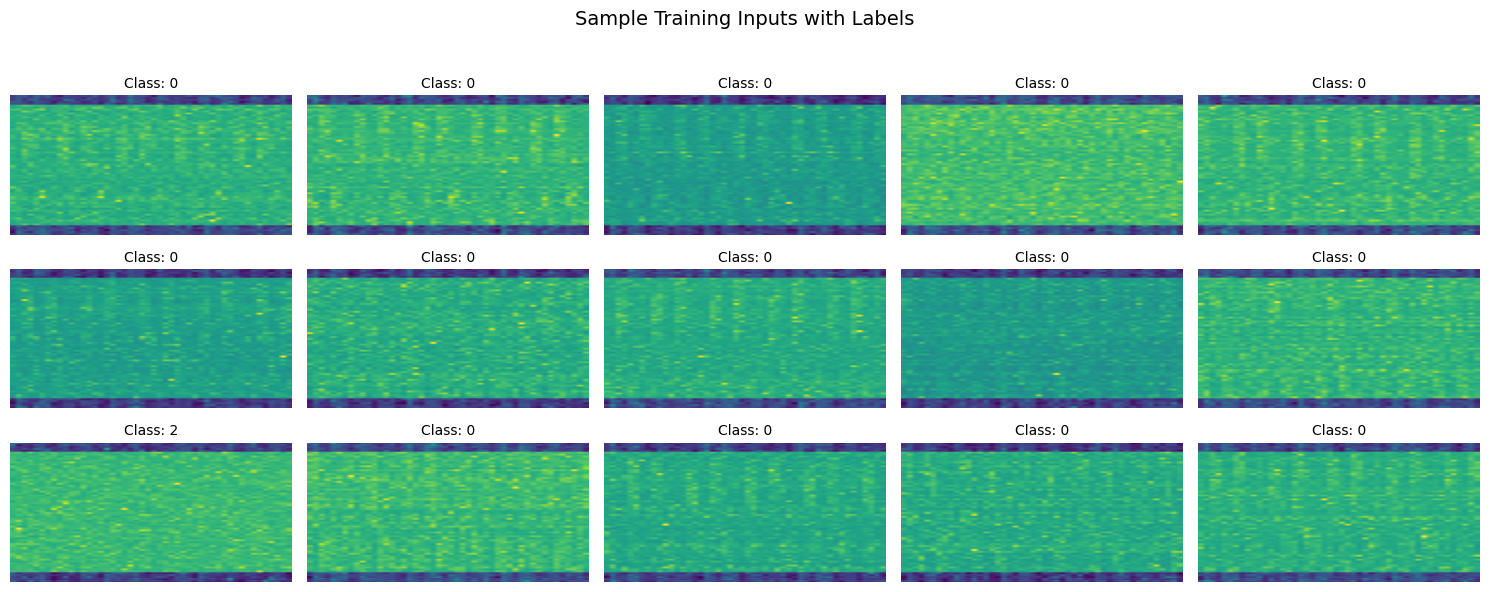

In [47]:
plt.figure(figsize=(15, 6))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_data[i].squeeze(), aspect='auto', cmap='viridis')
    plt.title(f"Class: {y_data[i]}", fontsize=10)
    plt.axis('off')

plt.suptitle("Sample Training Inputs with Labels", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Splits the data into training and validation sets.

In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

Defines a parameterized CNN model used for hyperparameter tuning.

In [29]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Choice("filters_1", [32, 64, 128]),
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        input_shape=(72, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    if hp.Boolean("add_second_conv"):
        model.add(Conv2D(filters=hp.Choice("filters_2", [64, 128]), kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(hp.Int("dense_units", 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Float("dropout", 0.3, 0.5, step=0.1)))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Performs hyperparameter tuning using Keras Tuner.

In [33]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=7,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='mlf_final_tuning'
)

tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose=2)

best_model = tuner.get_best_models(1)[0]

Trial 7 Complete [01h 17m 23s]
val_accuracy: 0.998327761888504

Best val_accuracy So Far: 0.998327761888504
Total elapsed time: 03h 57m 48s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Trains the best-found model using the training set and evaluates on the validation set.

In [42]:
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    verbose=2
)

Epoch 1/25
38/38 - 52s - 1s/step - accuracy: 0.9924 - loss: 0.0250 - val_accuracy: 0.9933 - val_loss: 0.0350
Epoch 2/25
38/38 - 79s - 2s/step - accuracy: 0.9916 - loss: 0.0246 - val_accuracy: 0.9732 - val_loss: 0.0853
Epoch 3/25
38/38 - 82s - 2s/step - accuracy: 0.9958 - loss: 0.0273 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 4/25
38/38 - 81s - 2s/step - accuracy: 0.9950 - loss: 0.0206 - val_accuracy: 0.9766 - val_loss: 0.1036
Epoch 5/25
38/38 - 49s - 1s/step - accuracy: 0.9908 - loss: 0.0249 - val_accuracy: 0.9900 - val_loss: 0.0739
Epoch 6/25
38/38 - 82s - 2s/step - accuracy: 0.9899 - loss: 0.0294 - val_accuracy: 0.9933 - val_loss: 0.0308
Epoch 7/25
38/38 - 50s - 1s/step - accuracy: 0.9916 - loss: 0.0246 - val_accuracy: 0.9666 - val_loss: 0.3079
Epoch 8/25
38/38 - 82s - 2s/step - accuracy: 0.9924 - loss: 0.0231 - val_accuracy: 0.9565 - val_loss: 0.2039
Epoch 9/25
38/38 - 82s - 2s/step - accuracy: 0.9941 - loss: 0.0221 - val_accuracy: 0.9833 - val_loss: 0.0610
Epoch 10/25
38/38 -

This block summarizes the model's training performance and validation accuracy.
First, it plots the accuracy and loss curves for both the training and validation datasets across epochs.
These visualizations help confirm that the model is learning correctly and not overfitting.

Then, it evaluates the model using a confusion matrix on the validation set.
This matrix shows how well the model distinguishes between the three classes.

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step
Validation Accuracy: 99.33%


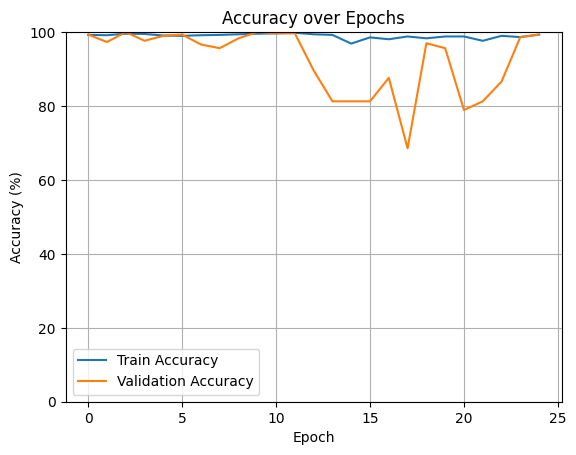

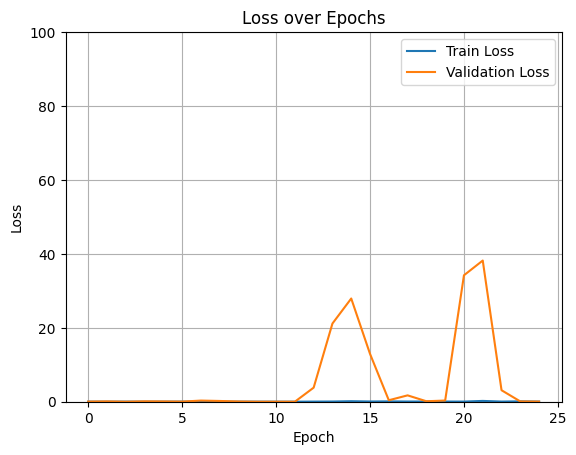

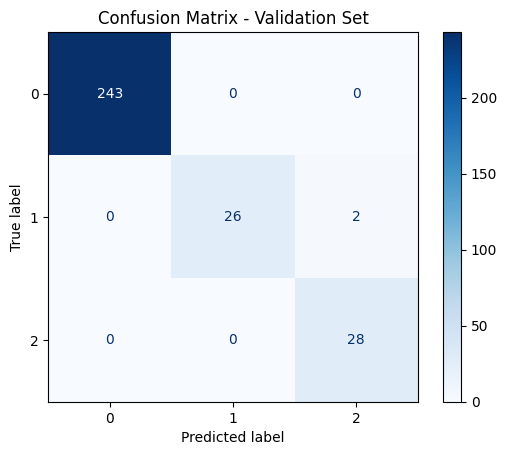

In [49]:
# Predict labels on validation set
y_val_pred = np.argmax(best_model.predict(X_val), axis=1)

# Evaluate and display validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Accuracy plot (converted to %)
plt.plot([a * 100 for a in history.history['accuracy']], label='Train Accuracy')
plt.plot([a * 100 for a in history.history['val_accuracy']], label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

# Loss plot (remains unchanged, but now scaled to 0–100 as requested)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.show()

Loads and processes test data samples for prediction.

In [50]:
test_files = sorted(os.listdir(TEST_DIR))
X_test = np.array([np.load(os.path.join(TEST_DIR, f)) for f in test_files])
X_test = X_test[..., np.newaxis].astype("float32") / np.max(X_data)

y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Creates the submission.csv file in the format required for Kaggle.

In [51]:
submission_df = pd.DataFrame({
    'File': test_files,
    'Label': y_pred_labels
})

submission_path = os.path.join(DATA_DIR, 'submission.csv')
submission_df.to_csv(submission_path, index=False)
print("submission.csv created at:", submission_path)

submission.csv created at: /content/drive/MyDrive/Colab Notebooks/MPA-MLF_DATA_NEW/submission.csv
